In [17]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt 

### Loading Price Data

In [18]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df
merged_data_summer = create_df('summer')


print(merged_data_summer.head())
merged_data_summer.head()

#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12


/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


            timestamp  Spotmarket_(EUR/kWh)  Inflexible_Demand_(kWh)  \
0 2023-08-01 00:00:00               0.07165                 0.076260   
1 2023-08-01 01:00:00               0.06910                 0.077891   
2 2023-08-01 02:00:00               0.06682                 0.077230   
3 2023-08-01 03:00:00               0.06406                 0.077059   
4 2023-08-01 04:00:00               0.06407                 0.076241   

   PV_energy_production_kWh  ev_at_home_binary  distance_driven  \
0                       0.0                  1              0.0   
1                       0.0                  1              0.0   
2                       0.0                  1              0.0   
3                       0.0                  1              0.0   
4                       0.0                  1              0.0   

   ev_home_availability  weekday  
0                   1.0        1  
1                   1.0        1  
2                   1.0        1  
3                   1.0 

,timestamp,Spotmarket_(EUR/kWh),Inflexible_Demand_(kWh),PV_energy_production_kWh,ev_at_home_binary,distance_driven,ev_home_availability,weekday
0,2023-08-01 00:00:00,0.07165,0.076260,0.0,1,0.0,1.0,1
1,2023-08-01 01:00:00,0.06910,0.077891,0.0,1,0.0,1.0,1
2,2023-08-01 02:00:00,0.06682,0.077230,0.0,1,0.0,1.0,1
3,2023-08-01 03:00:00,0.06406,0.077059,0.0,1,0.0,1.0,1
4,2023-08-01 04:00:00,0.06407,0.076241,0.0,1,0.0,1.0,1


### Dishwasher

In [19]:
# Load data
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
inflexibles = merged_data_summer["Inflexible_Demand_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")
    
#print(len(fridge))
#print(len(stove))
#print(len(tv))
#print(len(lighting))
#print(len(price))
#print(len(dishwasher_start))
#print(len(binary_dishwasher))
#print(len(start_times))



### Washing Machine

In [20]:
model.update()
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_WM_summer'] = 0  # Initialize with 0


# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 0



        
model.addConstrs((binary_wm[t] <= merged_data_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### Dryer 

In [21]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_dryer_summer'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 0

        
model.addConstrs((binary_dryer[t] <= merged_data_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")
#model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### EV - G2V

In [22]:
# Include EV
#EV properties

min_power_ev = 1 #kW, minimum power to charge the EV
max_power_ev = 10 #kW, maximum power to charge the EV
kwh_per_km = 0.2  # kWh per km driven

max_capacity_ev = 70 #kWh

#Variables
#state of charge of the EV at each time step
soc_ev = model.addVars(Time_interval,lb=0, ub=max_capacity_ev, vtype=GRB.CONTINUOUS, name="soc_ev")
#how much power is being charged at each time step
charging_ev = model.addVars(Time_interval,lb=0, ub=max_power_ev, vtype=GRB.CONTINUOUS, name="charging_lvl_ev")
#binary variable to indicate if the EV is being charged at each time step
binary_ev = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_ev")


# Enforce SoC at 7:00 every day (hour 7 of each day)
for d in range(Time_interval // 24):
    t = d * 24 + 7  # 7:00 each day
    if t < Time_interval:
        model.addConstr(soc_ev[t] >= 0.8*max_capacity_ev, name=f"ev_soc_7am_day_{d}")

# car can only charge if it is at home
model.addConstrs((binary_ev[t] <= merged_data_summer['ev_at_home_binary'][t] for t in range(len(binary_ev))), name="allowed_ev_summer")

# if car is at home, it can charge, but not more than the maximum power
# and if it is charging, it must be charging at least the minimum power
model.addConstrs((charging_ev[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * binary_ev[t] for t in range(Time_interval)), name="max_power_ev")
model.addConstrs((charging_ev[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * binary_ev[t] for t in range(Time_interval)), name="min_power_ev")

# Constrain ev storage

initial_soc_ev = 20
model.addConstr(soc_ev[0] == initial_soc_ev, name="ev_soc_initial")

model.addConstrs((soc_ev[t] == soc_ev[t-1] + charging_ev[t-1] - merged_data_summer['distance_driven'][t-1] * kwh_per_km for t in range(1,Time_interval)),name="ev_soc_update")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

### PV

In [23]:
#for power produced with the PV system, the price is 0 
# Total power consumption including fixed and dishwasher
total_load = {
    t: merged_data_summer['Inflexible_Demand_(kWh)'][t] +
       power_dishwasher * binary_dishwasher[t] +
       power_wm * binary_wm[t] + power_dryer * binary_dryer[t] + charging_ev[t]
    for t in range(Time_interval)
}
#add variable for total load minus the power produced by the PV system


#add gurobi variable that finds the min between load and pv production
# Binary on variables: 1 if dishwasher is on at hour t

pv_maxed_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="pv_maxed")  # z[t] = 1 if load >= pv
M = 10000 #1.2 * merged_data_summer['PV_energy_production_kWh'].max() # Choose M large enough to cover max difference between pv and load
unmet   = model.addVars(Time_interval, lb=0.0, name="unmet_load")
curtail = model.addVars(Time_interval, lb=0.0, name="curtail_pv")

for t in range(Time_interval):
    pv = merged_data_summer['PV_energy_production_kWh'][t]
    load = total_load[t]
    
    # Binary switch: if PV > load → binary = 0; else 1
    model.addConstr(pv - load + unmet[t] - curtail[t] == 0, name=f"pv_load_balance_{t}")
    model.addConstr(curtail[t] <= (1-pv_maxed_binary[t]) * M , name=f"curtail_pv_{t}_2")
    model.addConstr(unmet[t] <= pv_maxed_binary[t] * M, name=f"unmet_load_{t}_2")



### Peak Price 
If everyone implements this optimization, the price will have to be higher at peak times 

In [ ]:
model.update()
ε = 1e-3
wanted_steps = 6 #### change this and see that it is coherent with the other files... 
max_demand = max(inflexibles) + power_dishwasher + power_wm + power_dryer + max_power_ev
levels = np.arange(0, max_demand/2 + ε, max_demand/((wanted_steps -1)*2))
levels = np.append(levels, max_demand * 1.5 + 5)  # Ensure coverage

#multipllier for penalty costs per level increasing by 0.1 per level
multiplier_per_level = [0.05 * i for i in range(len(levels)-1)]
M_price = max_demand + 10

# Binary indicators per level per timestep
level_bin = [
    [model.addVar(vtype=GRB.BINARY, name=f"level_bin[{t},{i}]") for i in range(len(levels)-1)]
    for t in range(Time_interval)
]

# Integer index of active level
demand_level = [
    model.addVar(lb=0, ub=len(levels) - 1, vtype=GRB.INTEGER, name=f"demand_level[{t}]")
    for t in range(Time_interval)
]

# Total demand per timestep
total_demand = model.addVars(Time_interval, lb=0, ub=max_demand, vtype=GRB.CONTINUOUS, name="total_demand")

# Constraint: calculate total demand
for t in range(Time_interval):
    model.addConstr(
        total_demand[t] ==
        unmet[t], name=f"total_demand_from_grid_calc_{t}"
    )

# Constraint: only one level active at a time
for t in range(Time_interval):
    model.addConstr(gp.quicksum(level_bin[t]) == 1, name=f"one_level_active_{t}")

# Constraint: bind total_demand to its level using Big-M
for t in range(Time_interval):
    for i in range(len(levels) - 1):
        model.addConstr(
            total_demand[t] >= levels[i] - (1 - level_bin[t][i]) * M_price,
            name=f"lower_bound_level_{t}_{i}"
        )
        model.addConstr(
            total_demand[t] <= levels[i + 1] - ε + (1 - level_bin[t][i]) * M_price,
            name=f"upper_bound_level_{t}_{i}"
        )
    # Calculate demand_level from binary selection
    model.addConstr(
        demand_level[t] == gp.quicksum(i * level_bin[t][i] for i in range(len(levels)-1)),
        name=f"demand_level_calc_{t}"
    )

#generate penalty costs for each level that depend on a const and a linear term
penalty_per_level = [multiplier_per_level[i] * levels[i] for i in range(len(levels)-1)]



# Penalty term as an expression
penalty_cost = gp.quicksum(
    penalty_per_level[i] * level_bin[t][i]
    for t in range(Time_interval)
    for i in range(len(levels)-1)
)

print(levels)
print(multiplier_per_level)
print(penalty_per_level)


[ 0.          2.1280347   4.25606941  6.38410411  8.51213881 10.64017351
 36.92052054]
[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25]
[0.0, 0.10640173513122596, 0.42560694052490383, 0.9576156161810336, 1.7024277620996153, 2.6600433782806485]


### Objective Function and Optimization

In [38]:
# Objective: minimize total electricity cost + penalty
model.setObjective(
    gp.quicksum(price[t] * unmet[t] - curtail[t] * 0 for t in range(Time_interval)) + penalty_cost,
    GRB.MINIMIZE
)

model.update()
model.optimize()



Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 34276 rows, 20084 columns and 93693 nonzeros
Model fingerprint: 0xbc3dc3dd
Variable types: 4464 continuous, 15620 integer (14132 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+04]
  Objective range  [2e-03, 3e+00]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e-04, 1e+04]

MIP start from previous solve produced solution with objective 45.3361 (0.13s)
MIP start from previous solve produced solution with objective 45.0232 (0.16s)
Loaded MIP start from previous solve with objective 45.0232

Presolve removed 26640 rows and 11459 columns
Presolve time: 0.69s
Presolved: 7636 rows, 8625 columns, 37984 nonzeros
Variable types: 1075 continuous, 7550 integer (7550 binary)

Root relaxation: objective 2.988670e+01, 5657 iterations, 0.17 sec

### Debugging

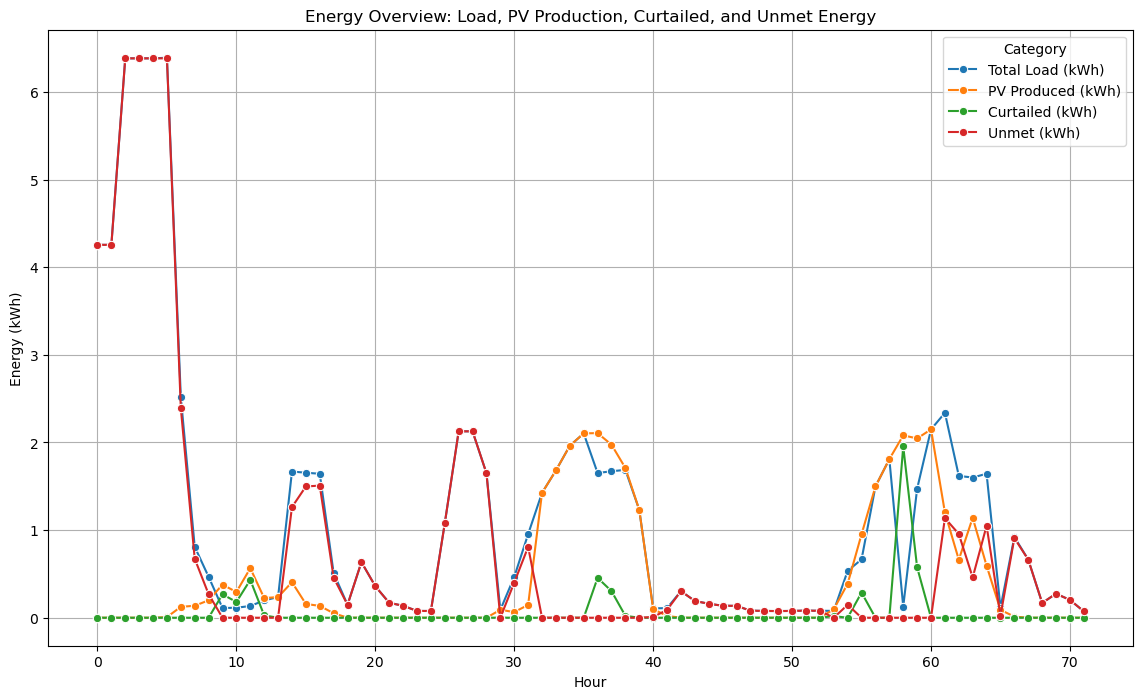

In [39]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Prepare data for plotting
time_range = range(Time_interval)  # Full time range
# Limit the time range to the first two weeks (2 weeks * 7 days * 24 hours = 336 hours)
time_range = range(72)

data_plot = pd.DataFrame({
    'Hour': list(time_range),
    'Total Load (kWh)': [total_load[t].getValue() for t in time_range],
    'PV Produced (kWh)': merged_data_summer['PV_energy_production_kWh'].iloc[:72].values,
    'Curtailed (kWh)': [curtail[t].X for t in time_range],
    'Unmet (kWh)': [unmet[t].X for t in time_range]
})

# Melt the data for easier plotting
data_plot_melted = data_plot.melt(id_vars='Hour', var_name='Category', value_name='Energy (kWh)')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_plot_melted, x='Hour', y='Energy (kWh)', hue='Category', marker='o')
plt.title('Energy Overview: Load, PV Production, Curtailed, and Unmet Energy')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend(title='Category')
plt.grid(True)
plt.show()

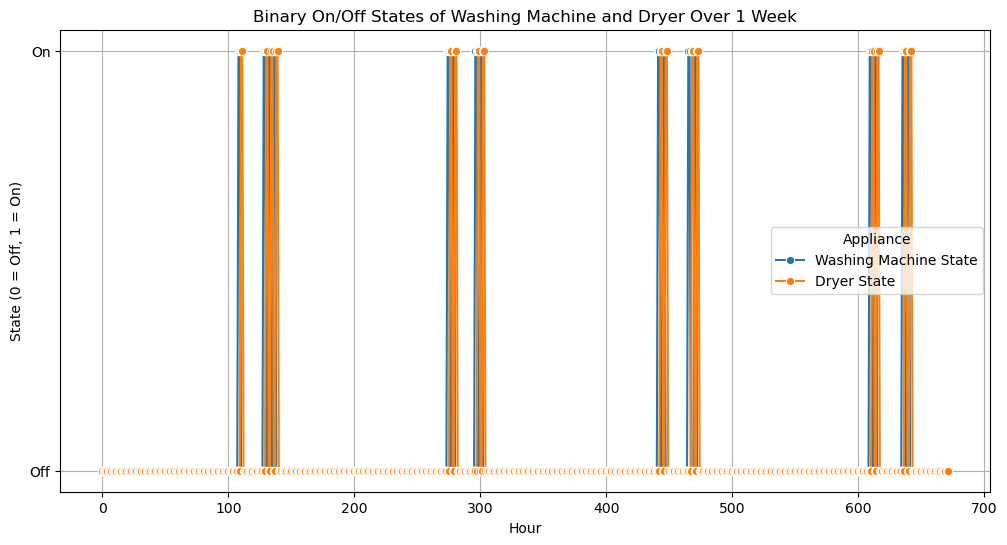

In [40]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week (or adjust as needed)
time_range = range(0,7*24*4)  # 7 days, 24 hours each

# Prepare DataFrame for binary on/off states
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Washing Machine State': [binary_wm[t].X for t in time_range],
    'Dryer State': [binary_dryer[t].X for t in time_range]
})

# Melt for plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dryer Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()

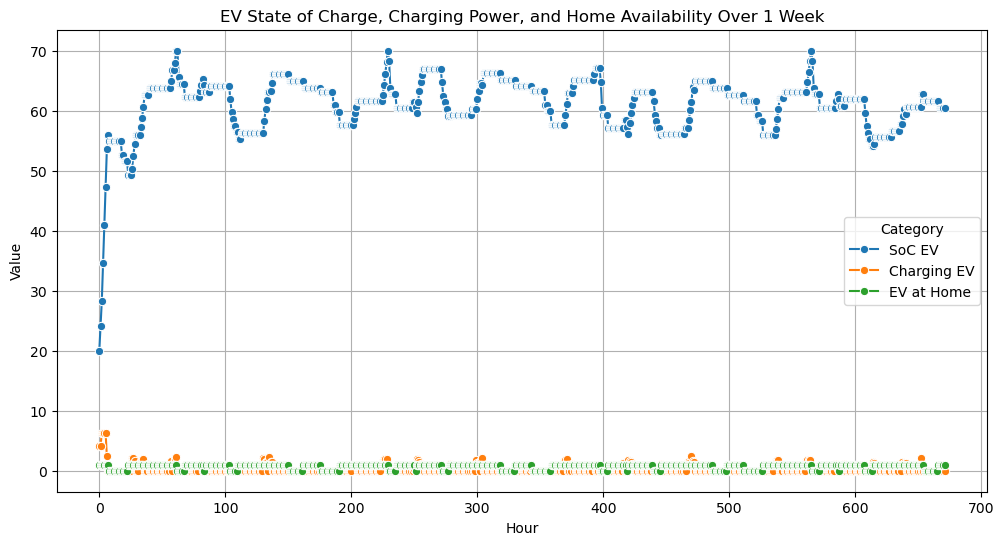

In [41]:
#plot the state of charge of the EV the driving and binary if at home or not 

data_ev = pd.DataFrame({
    'Hour': list(time_range),
    'SoC EV': [soc_ev[t].X for t in time_range],
    'Charging EV': [charging_ev[t].X for t in time_range],
    'EV at Home': [merged_data_summer['ev_at_home_binary'][t] for t in time_range]
})
# Melt for plotting
data_ev_melted = data_ev.melt(id_vars='Hour', var_name='Category', value_name='Value')
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_ev_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('EV State of Charge, Charging Power, and Home Availability Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()


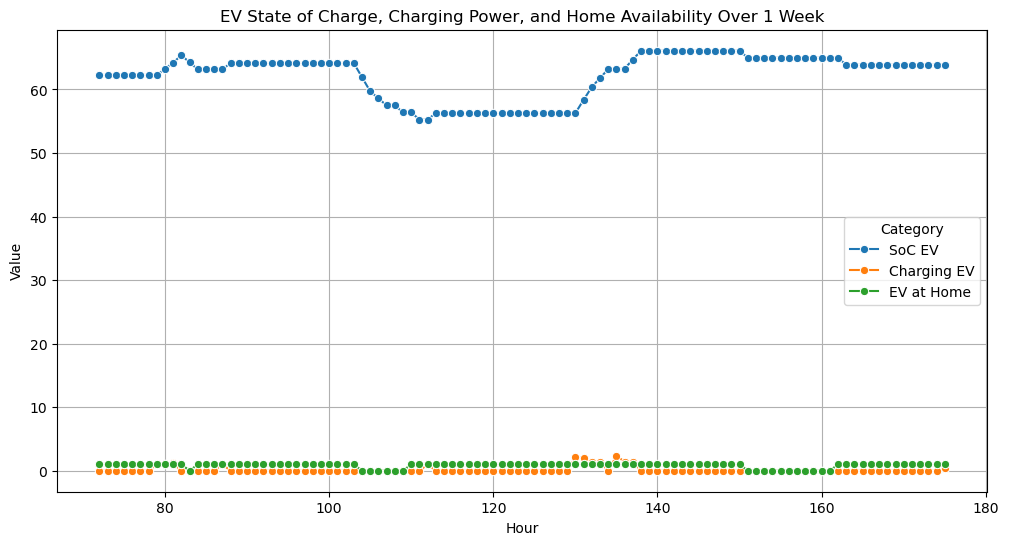

In [42]:
#same plot as before but just for one week
data_ev_one_week = pd.DataFrame({
    'Hour': list(range(72,176)),  # 7 days, 24 hours each
    'SoC EV': [soc_ev[t].X for t in range(72,176)],
    'Charging EV': [charging_ev[t].X for t in range(72,176)],
    'EV at Home': [merged_data_summer['ev_at_home_binary'][t] for t in range(72,176)]
})
# Melt for plotting
data_ev_one_week_melted = data_ev_one_week.melt(id_vars='Hour', var_name='Category', value_name='Value')    
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_ev_one_week_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('EV State of Charge, Charging Power, and Home Availability Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()

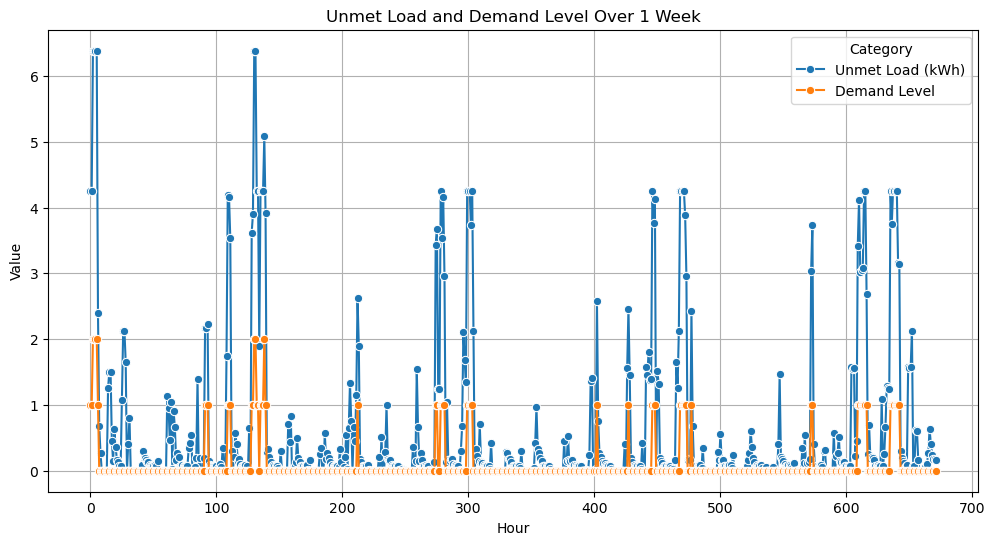

In [43]:
#plot unmet and demand level with different axis
data_unmet = pd.DataFrame({
    'Hour': list(time_range),
    'Unmet Load (kWh)': [unmet[t].X for t in time_range],
    'Demand Level': [demand_level[t].X for t in time_range]
})
# Melt for plotting
data_unmet_melted = data_unmet.melt(id_vars='Hour', var_name='Category', value_name='Value')
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_unmet_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('Unmet Load and Demand Level Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)  
plt.show()


In [35]:
#print unmet in hour 0
print(f"Unmet load at hour 0: {unmet[0].X} kWh")


Unmet load at hour 0: 5.319086756561298 kWh


In [36]:
#print demand level and unmet load for each hour
for t in range(Time_interval):
    print(f"Hour {t}: Demand Level = {demand_level[t].X}, Unmet Load = {unmet[t].X} kWh")

Hour 0: Demand Level = 0.0, Unmet Load = 5.319086756561298 kWh
Hour 1: Demand Level = 0.0, Unmet Load = 5.319086756561298 kWh
Hour 2: Demand Level = 0.0, Unmet Load = 5.319086756561298 kWh
Hour 3: Demand Level = 0.0, Unmet Load = 5.319086756561298 kWh
Hour 4: Demand Level = 0.0, Unmet Load = 5.319086756561298 kWh
Hour 5: Demand Level = 0.0, Unmet Load = 5.319086756561298 kWh
Hour 6: Demand Level = 0.0, Unmet Load = 4.518651612339852 kWh
Hour 7: Demand Level = 0.0, Unmet Load = 0.6727377605866345 kWh
Hour 8: Demand Level = 0.0, Unmet Load = 0.26834717694889765 kWh
Hour 9: Demand Level = 0.0, Unmet Load = 0.0 kWh
Hour 10: Demand Level = 0.0, Unmet Load = 0.0 kWh
Hour 11: Demand Level = 0.0, Unmet Load = 0.0 kWh
Hour 12: Demand Level = 0.0, Unmet Load = 0.0 kWh
Hour 13: Demand Level = 0.0, Unmet Load = 0.0005025855828203196 kWh
Hour 14: Demand Level = 0.0, Unmet Load = 1.262276759822573 kWh
Hour 15: Demand Level = 0.0, Unmet Load = 1.4977018455122348 kWh
Hour 16: Demand Level = 0.0, Unmet